In [1]:
%matplotlib inline
import sys
sys.path.append("/media/yifan/Windows/Users/xie/Playground/Numerai/")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import feather
import gc
import paratext
import xgboost as xgb
from IPython.display import display

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.cross_validation import StratifiedKFold
from sklearn.metrics import log_loss
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import SelectPercentile
from sklearn.feature_selection import chi2




from bayes_opt import BayesianOptimization


import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)
pd.set_option('display.max_seq_items', 200)
pd.set_option('max_rows', 200)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [3]:
train=pd.read_csv('./data/numerai_training_data.csv')
test=pd.read_csv('./data/numerai_tournament_data.csv')
submit=pd.read_csv('./data/example_predictions.csv')

In [41]:
train_target=train['target'].as_matrix()

train_features=train.drop(['target'], axis=1).as_matrix()
test_features=test.drop(['t_id'], axis=1).as_matrix()
train_features=np.sqrt(train_features+3/8)
test_features=np.sqrt(test_features+3/8)

In [4]:
def score(clf, train_data, y, random_state = 0, print_score=True):
    kf = StratifiedKFold(y, n_folds=5, shuffle=True, random_state=random_state)
    pred = np.zeros((y.shape[0],2))
    counter=0
    errlist=[]
    for itrain, itest in kf:
        counter+=1
        Xtr, Xte = train_data[itrain, :], train_data[itest, :]
        ytr, yte = y[itrain], y[itest]
        clf.fit(Xtr, ytr)
        pred[itest,:] = clf.predict_proba(Xte)
        err=log_loss(yte, pred[itest,:])
        if print_score:
            print("score {} is {:.5f}".format(counter, err, end=' '))
        errlist.append(err)

    if print_score:
        print("mean score is {:.5f}".format(np.mean(errlist)))
    return log_loss(y, pred), pred

In [76]:
def xgb_model(labels, traindata, testdata, booster="gbtree", tree_method='exact', num_rounds=50):
    params = {}
    if booster=="gbtree":
        params["booster"]="gbtree"
        params["eta"] = 0.1
        params["subsample"] = 1
        params["colsample_bytree"] = 0.5
        params["max_depth"] = 2
        params["tree_method"]=tree_method
    else: 
        params["booster"]="gblinear"
        params["eta"] = 0.1
        params["lambda"]=1
        params["lambda_bias"]=1
    
    params["objective"] = "multi:softprob"
    params["num_class"]=2
    params["nthread"]=8
    
#     params["gamma"]=0.1 #0.277
#     params["silent"] = 1
    plst = list(params.items())
    xgbtrain = xgb.DMatrix(traindata, label=labels)
    xgbtest = xgb.DMatrix(testdata)

#     print("fitting model")
    model = xgb.train(plst, xgbtrain, num_rounds)
    
#     print("making prediction")
    preds = model.predict(xgbtest)
    
    return preds

In [98]:
def xgb_score(train_data, y, random_state = 0, print_score=True):
    kf = StratifiedKFold(y, n_folds=5, shuffle=True, random_state=random_state)
    pred = np.zeros((y.shape[0],2))
    counter=0
    errlist=[]
    for itrain, itest in kf:
        counter+=1
        Xtr, Xte = train_data[itrain, :], train_data[itest, :]
        ytr, yte = y[itrain], y[itest]


#         pred[itest,:]=xgb_model(ytr, Xtr, Xte, booster="gbtree")
#         pred[itest,:]=xgb_model(ytr, Xtr, Xte, booster="gblinear", num_rounds=200)
        pred1=xgb_model(ytr, Xtr, Xte, booster="gbtree")
#         pred2=xgb_model(ytr, Xtr, Xte, booster="gblinear", num_rounds=200)
        
        pred2=LogisticRegression(C=0.02,solver='lbfgs').fit(Xtr, ytr).predict_proba(Xte)
        
        pred[itest,:]=(pred1*0.5+pred2*0.5)

#         clf.fit(Xtr, ytr)
#         pred[itest,:] = clf.predict_proba(Xte)

        err=log_loss(yte, pred[itest,:])
        if print_score:
            print("score {} is {:.5f}".format(counter, err, end=' '))
        errlist.append(err)

    if print_score:
        print("mean score is {:.5f}".format(np.mean(errlist)))
    return log_loss(y, pred), pred

In [114]:
selectP_value=85
ch2=SelectPercentile(chi2, percentile=selectP_value)
select_train=ch2.fit_transform(train_features, train_target)
select_test=ch2.transform(test_features)

# score1, pred=xgb_score(train_features, train_target)

score1, pred=xgb_score(select_train, train_target)

score 1 is 0.69153
score 2 is 0.69232
score 3 is 0.69149
score 4 is 0.69115
score 5 is 0.69119
mean score is 0.69154


In [144]:
clf=LogisticRegression(C=0.5,solver='lbfgs')
clf.fit(train_features, train_target)
test_pred_proba= clf.predict_proba(test_features)
test_pred_int=clf.predict(test_features)


In [103]:
selectP_value=83
ch2=SelectPercentile(chi2, percentile=selectP_value)
select_train=ch2.fit_transform(train_features, train_target)
select_test=ch2.transform(test_features)

lgclf=LogisticRegression(C=0.5,solver='lbfgs')
lgclf.fit(select_train, train_target)
lg_pred_proba= lgclf.predict_proba(select_test)
lg_pred_int=lgclf.predict(select_test)


xgb_pred_proba=xgb_model(train_target, select_train, select_test, booster="gbtree")

pred=lg_pred_proba*0.5+xgb_pred_proba*0.5


In [102]:
n=0
for n in range(10):
    print (train_target[n], lg_pred_int[n], lg_pred_proba[n], xgb_pred_proba[n])


1 0 [ 0.50243016  0.49756984] [ 0.49548233  0.50451767]
1 0 [ 0.51564438  0.48435562] [ 0.50892568  0.49107429]
1 1 [ 0.44398309  0.55601691] [ 0.46180329  0.53819674]
1 0 [ 0.52195959  0.47804041] [ 0.50463426  0.49536577]
0 0 [ 0.52208584  0.47791416] [ 0.4954831  0.5045169]
1 1 [ 0.47288925  0.52711075] [ 0.46929744  0.53070259]
1 1 [ 0.48454261  0.51545739] [ 0.49191871  0.50808126]
0 1 [ 0.48417051  0.51582949] [ 0.47716671  0.52283329]
0 1 [ 0.47029531  0.52970469] [ 0.48530513  0.51469487]
0 1 [ 0.47902956  0.52097044] [ 0.49101412  0.50898588]


In [111]:
submit_pred=submit.copy(deep=True)
submit_pred['probability']=pred[:,1]

submit_pred.to_csv('./submit_lg_xgb.csv', index=False)

In [113]:
submit_pred.head(5)

,t_id,probability
0,7726,0.501
1,15876,0.488
2,22137,0.547
3,22770,0.487
4,33025,0.491


In [112]:
submit.head(5)

,t_id,probability
0,7726,0.509
1,15876,0.510
2,22137,0.535
3,22770,0.493
4,33025,0.497


/home/yifan/playground/anaconda3/envs/snakes/lib/python3.5/site-packages/sklearn/feature_selection/univariate_selection.py:407: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  kept_ties = ties[:max_feats - mask.sum()]


Score for 50.00 is 0.692066 
Score for 55.56 is 0.692021 
Score for 61.11 is 0.691991 
Score for 66.67 is 0.691983 
Score for 72.22 is 0.691985 
Score for 77.78 is 0.691964 
Score for 83.33 is 0.691940 
Score for 88.89 is 0.691944 
Score for 94.44 is 0.691946 
Score for 100.00 is 0.691950 


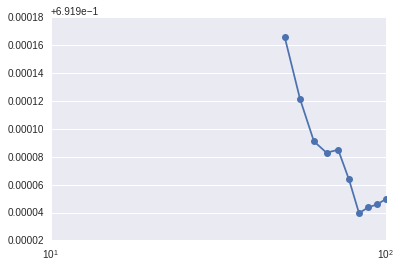

In [58]:
Ps = np.linspace(50, 100, num=10)
res=[]
for P in Ps:
    selectP_value=P
    ch2=SelectPercentile(chi2, percentile=selectP_value)
    select_train=ch2.fit_transform(train_features, train_target)
    select_test=ch2.transform(test_features)
    err=score(LogisticRegression(C=0.02, multi_class='multinomial',solver='lbfgs'), select_train, train_target)
    print("Score for %.2f is %.6f " %(P, err))
    res.append(err)

plt.semilogx(Ps, res,'-o');

In [38]:
k_fold_score

0.6919495752793644

In [56]:
np.linspace(5, 10, num=5)

array([  5.  ,   6.25,   7.5 ,   8.75,  10.  ])

In [31]:
train_features.shape

(96320, 21)

In [32]:
train_target.shape

(96320,)